# This notebook contains the code for section 3.7


In [13]:
using DynamicPolynomials
using JuMP
using MosekTools
using LinearAlgebra
using CSV
using DataFrames
import DelimitedFiles
import JSON
using Dates
using Gurobi

# Kepler example: Recovering missing axioms via experimental data

Let us revisit Kepler's law, but with missing axioms and data to recover them

In [14]:
function all_monomials_up_to_max_deg(x, deg)
    if size(x,1) == 0
        [1]
    else
    [ x[1]^k * m for k=0:deg 
            for m=all_monomials_up_to_max_deg(x[2:end], deg)
    ]
    end
end

function mons_of_max_degree_and_unit(x, deg, u)
    [m
        for m=all_monomials_up_to_max_deg(x, deg)
        #if all(unit(m) .== u)
    ]
end

# ------

function all_monomials_up_to_max_deg_overall(x, deg, deg_overall, deg_elem)
    if size(x,1) == 0
        [1]
    else
    [ x[1]^k * m for k=0:min(deg, deg_overall, deg_elem[1]) 
                for m=all_monomials_up_to_max_deg_overall(x[2:end], deg, deg_overall-k, deg_elem[2:end])
    ]
    end
end

function mons_of_max_degree_and_unit_overall(x, deg, deg_overall, deg_elem, u)
    [m
        for m=all_monomials_up_to_max_deg_overall(x, deg, deg_overall, deg_elem)
        #if all(unit(m) .== u)
    ]
end
                
function degree_poly(p)
    maximum(degree.(monomials(p)))
end

# ------

function degree_poly(p)
    maximum(degree.(monomials(p)))
end

degree_poly (generic function with 1 method)

In [15]:
@polyvar m₁ m₂ d₁ d₂ p w Fg Fc
#@polyvar m₁ m₂ d₁ d₂ p w Fg Fc G
x =[m₁, m₂, d₁, d₂, p, w, Fg, Fc]
#x =[m₁, m₂, d₁, d₂, p, w, Fg, Fc, G]

8-element Vector{Variable{DynamicPolynomials.Commutative{DynamicPolynomials.CreationOrder}, Graded{LexOrder}}}:
 m₁
 m₂
 d₁
 d₂
 p
 w
 Fg
 Fc

In [16]:
axioms = [
        # d₁*m₁ - d₂*m₂, #Suppressing this axiom for now, aiming to recover Kepler anyway
        (d₁+d₂)^2*Fg-m₁*m₂,
        Fc-m₂*d₂*w^2,
        Fg-Fc,
        w*p-1
         ]

4-element Vector{Polynomial{DynamicPolynomials.Commutative{DynamicPolynomials.CreationOrder}, Graded{LexOrder}, Int64}}:
 -m₁m₂ + d₂²Fg + 2d₁d₂Fg + d₁²Fg
 Fc - m₂d₂w²
 -Fc + Fg
 -1 + pw

In [17]:
n_dat=1000
N_data_points = parse(Int, readuntil(string(n_dat)*"/data_kepler_n_points.dat"," "))
data_bin_star = DelimitedFiles.readdlm(string(n_dat)*"/data_kepler.dat")
d= DelimitedFiles.readdlm(string(n_dat)*"/data_kepler_d.dat")

for i=1:N_data_points # CRI up to n
   data_bin_star[i,4]=d[i]*data_bin_star[i,3]/(data_bin_star[i,2]+data_bin_star[i,3]) 
    data_bin_star[i,5]=d[i]*data_bin_star[i,2]/(data_bin_star[i,2]+data_bin_star[i,3]) 
end
data_bin_star=data_bin_star[:,[2,3,4,5,1]] # Move period to end, to be consistent with model



1000×5 Matrix{Float64}:
 0.580123  1.10358   23.3022   12.2493   163.363
 1.39261   1.16416   29.5856   35.3912   327.56
 1.03506   0.519007  39.4545   78.6846  1030.04
 1.74977   1.81549   39.8273   38.3855   366.329
 1.24695   1.18385   46.086    48.5424   590.416
 1.15399   1.6623    62.8049   43.5998   654.038
 1.28528   1.52053   52.4889   44.368    569.072
 1.97616   0.728341  12.236    33.1993   186.229
 1.66055   1.32426   27.1245   34.0127   276.694
 1.93864   0.526097  31.8466  117.353   1160.82
 0.950644  0.990058  43.4256   41.6968   563.749
 1.1348    0.599379  49.5021   93.7222  1301.6
 1.82999   0.821339  44.7452   99.6948  1066.1
 ⋮                                      
 0.763103  1.84782   26.9953   11.1484   145.793
 1.71608   1.27927   55.4744   74.4165   855.35
 0.688741  1.27975   20.5561   11.063    126.724
 0.827847  0.633459  63.0974   82.46    1452.72
 1.23825   1.24229   48.8609   48.7022   611.865
 1.94267   0.902853  28.0097   60.2683   491.697
 1.40185   0.

# Now defining the get distance function, and running experiments: 

Note that we are seeking the formula
```-2.0m₂d₁d₂² - m₂d₁²d₂ - m₁d₁d₂² + m₁m₂p²G```
This is one (not the only) version of the correct formula

In [25]:
function get_distance(N_data_points)
    ### deg = 2
    deg_overall=6
    deg_overall_q=4
    
    deg_elementwise=[2, 2, 2, 2, 2, 2, 2, 2, 2] 
    deg_elementwise_q=[2, 2, 2, 2, 2] # CRI num of measurable vars #To be checked: is this enough?
    #deg_elementwise_q=[2, 2, 2, 2, 2, 2] # with G
    
    deg = 2
    
    #M=10
    
    candidate_mons = [
        mons_of_max_degree_and_unit_overall(x, deg, deg_overall, deg_elementwise, [])
        for ai=axioms
    ]
    
    # @show size.(candidate_mons)
    
    model = Model(Gurobi.Optimizer)
    # set_optimizer_attribute(model, "OptimalityTol", 1e-7)
    # set_optimizer_attribute(model, "FeasibilityTol", 1e-7)
    # set_optimizer_attribute(model, "IntFeasTol", 1e-7)
    set_optimizer_attribute(model, "MIPGap", 1e-9)
    set_optimizer_attribute(model, "Quad", 1)
    set_optimizer_attribute(model, "NumericFocus", 3)
    set_optimizer_attribute(model, "Method", 0)
    set_optimizer_attribute(model, "NodeMethod", 0)
    
    
    mons_q = mons_of_max_degree_and_unit_overall([p, m₁, m₂, d₁, d₂] , deg, deg_overall_q, deg_elementwise_q, [])
    # mons_q = mons_of_max_degree_and_unit_overall([p, m₁, m₂, d₁, d₂, G] , deg, deg_overall_q, deg_elementwise_q, [])
    coeff_q =   @variable(model, [1:size(mons_q,1)], base_name="q")
    abs_coeff_q =   @variable(model, [1:size(mons_q,1)], base_name="q")
    
    q = sum(ci .* mi for (ci, mi)=zip(coeff_q, mons_q)) # Zip pairs things without needing a ref index, e.g., zip([1, 2, 3], [4,5,6])=((1,4), (2,5), (3,6))
    coeff_αs = [
        @variable(model, [1:size(X,1)], base_name="α$i")
        for (i,X)=enumerate(candidate_mons)
        ]
    
    #@show size.(coeff_αs)
    
    αs = [sum(ci .* mi) for (ci, mi)=zip(coeff_αs, candidate_mons)]
    
    residual = q - sum(αᵢ * aᵢ for (αᵢ, aᵢ)=zip(αs,axioms));
    eqs = coefficients(residual)
    
    
    # @variable(model, z[i=1:size(axioms,1)], Bin)
    
    
    @variable(model, abseqs[i=1:size(eqs,1)])
    @constraint model abseqs.>=eqs
    @constraint model abseqs.>=-eqs
    
    
    #@constraint(model, sum(z)<=k)
    
    # Ensure that the sum of the coefficients on the terms involving p^2 isn't zero, in order that p^2 is part of expression
    @constraint model sum(coeff_q[degree.(mons_q, p).>0]) == 1.0
    
    
    # @constraint model eqs .== 0
    @constraint model abs_coeff_q.>=coeff_q
    @constraint model abs_coeff_q.>=-coeff_q
    
    @variable(model, t[i=1:N_data_points]>=0.0) 
    @constraint(model, imposeabs1[i=1:N_data_points], t[i]>=q(data_bin_star[i,:]))
    @constraint(model, imposeabs2[i=1:N_data_points], t[i]>=-q(data_bin_star[i,:]))
    
    
    
    # constraint to force at least one element to do not contain p
    M = 10^3
    @variable(model, z, Bin)
    @constraint model sum(coeff_q[degree.(mons_q, p).==0]) >= 0.1 - M * z
    @constraint model sum(coeff_q[degree.(mons_q, p).==0]) <= -0.1 + M*(1-z)
    
    
    # OBJECTIVE
    weight_1=0.9
    weight_2=0.01
    @objective model Min (weight_1/sqrt(N_data_points))*sum(t) + weight_2*sum(abs_coeff_q) + (1.0-weight_1-weight_2)*sum(abseqs)
    
    @constraint(model, sum(t)<=10^(-8)*N_data_points) #Data is noiseless, so strongly incentivize fidelity to data
    
    optimize!(model)
    
    value_poly2 = p -> sum(value.(coefficients(p)).* monomials(p))

    @show value_poly2(q)

    # @show value_αs=value_poly2.(αs)

    # Enumerate all versions of Kepler law that are isomorphic under missing axiom and show up in practice
    ground_truth_poly=-2*m₂*d₁*d₂^2 - m₂*d₁^2*d₂ - m₁*d₁*d₂^2 + m₁*m₂*p^2

    ground_truth_poly2=-m₂*d₁^2*d₂ - m₁*d₁*d₂^2 -2*m₁*d₁^2*d₂+ m₁*m₂*p^2

    ground_truth_poly3=-m₂*d₁*d₂^2-m₂*d₁^2*d₂ - m₁*d₁*d₂^2 -m₁*d₁^2*d₂+ m₁*m₂*p^2


    thedistance=min(sum(abs.(coefficients(value_poly2(q)-ground_truth_poly))), sum(abs.(coefficients(value_poly2(q)+ground_truth_poly))), sum(abs.(coefficients(value_poly2(q)-ground_truth_poly2))), sum(abs.(coefficients(value_poly2(q)+ground_truth_poly2))), sum(abs.(coefficients(value_poly2(q)+ground_truth_poly3))), sum(abs.(coefficients(value_poly2(q)-ground_truth_poly3))))

    @show N_data_points

    @show thedistance
    @show sum(value.(t))


    return thedistance
end

get_distance (generic function with 1 method)

In [33]:
n_dats=1:1:100
thedistances=zeros(length(n_dats))
i=1
for N_data_points in n_dats
    thedistances[i]=get_distance(N_data_points)
    i=i+1
end



Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-14
Set parameter MIPGap to value 1e-09
Set parameter Quad to value 1
Set parameter NumericFocus to value 3
Set parameter Method to value 0
Set parameter NodeMethod to value 0
Set parameter Method to value 0
Set parameter NumericFocus to value 3
Set parameter MIPGap to value 1e-09
Set parameter Quad to value 1
Set parameter NodeMethod to value 0
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 18648 rows, 16263 columns and 53589 nonzeros
Model fingerprint: 0xfa44bf44
Variable types: 16262 continuous, 1 integer (1 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+07]
  Objective range  [1e-02, 9e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-08, 1e+03]
Presolve removed 18479 rows and 15979 columns
Presolve time: 0.05s
Presolved: 169 rows

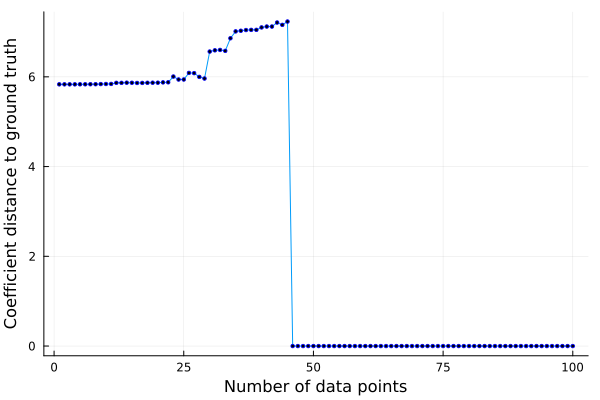

In [ ]:
using Plots
gr()
plot(n_dats, thedistances, xlabel="Number of data points", ylabel="Coefficient distance to ground truth",m = (2, :black, stroke(1, :blue)), legend=false)
# With a constraint that sum(t)<= 10^-8*num data points

In [ ]:
savefig("Distance_vs_noise_kepler_noiselesscase_axiom1missing.pdf")
# Appears to recover the ground truth with n>=46 data points when the first axiom is missing

"/Users/rcorywri/Dropbox/Symbolic_Discovery/Kepler_With_Missing_Axioms/data-seed-1432406613/no noise/Distance_vs_noise_kepler_noiselesscase_axiom1missing.pdf"

In [28]:
# Changing the axiom we hide to all axioms missing
axioms = [
    # add noise to the coefficients in the axioms
        0
         ]


1-element Vector{Int64}:
 0

In [29]:
# Same thing, but with all axioms hidden
n_dats=1:1:100
thedistances=zeros(length(n_dats))
i=1
for N_data_points in n_dats
    thedistances[i]=get_distance(N_data_points)
    i=i+1
end


Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-14
Set parameter MIPGap to value 1e-09
Set parameter Quad to value 1
Set parameter NumericFocus to value 3
Set parameter Method to value 0
Set parameter NodeMethod to value 0
Set parameter Method to value 0
Set parameter NumericFocus to value 3
Set parameter MIPGap to value 1e-09
Set parameter Quad to value 1
Set parameter NodeMethod to value 0
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 390 rows, 2001 columns and 1111 nonzeros
Model fingerprint: 0x5f5dfe4e
Variable types: 2000 continuous, 1 integer (1 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+07]
  Objective range  [1e-02, 9e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-08, 1e+03]
Presolve removed 307 rows and 1843 columns
Presolve time: 0.00s
Presolved: 83 rows, 158 col

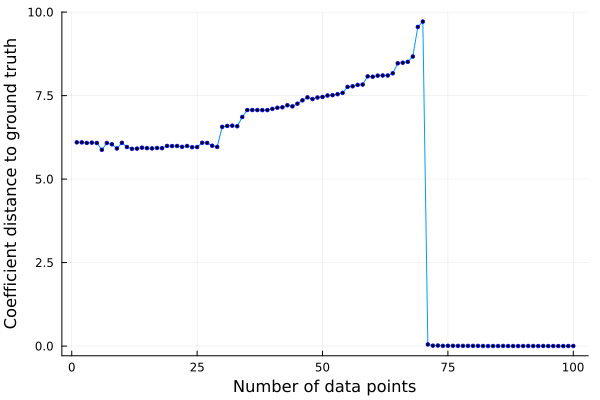

In [30]:
using Plots
gr()
plot(n_dats, thedistances, xlabel="Number of data points", ylabel="Coefficient distance to ground truth",m = (2, :black, stroke(1, :blue)), legend=false)

In [31]:
savefig("Distance_vs_noise_kepler_noiselesscase_allaxiomsmissing.pdf")
# Appears to recover the ground truth with n>=71 data points when the second axiom is missing

"/Users/rcorywri/Dropbox/Symbolic_Discovery/Kepler_With_Missing_Axioms/data-seed-1432406613/no noise/Distance_vs_noise_kepler_noiselesscase_allaxiomsmissing.pdf"